In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams["figure.figsize"] = [1, 5]
plt.rcParams["figure.dpi"] = 100
plt.style.use('seaborn-notebook')
sns.set_style("ticks")
sns.despine(offset=10, trim=True)
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')
from time import sleep

from math import sqrt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.callbacks import Callback

import ccxt
import exchange_poloniex as expx

Using TensorFlow backend.


In [2]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

plot_learning = PlotLearning()

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def transform_diff(vals):
    d = []
    o = vals[0]
    for n in vals[1:]:
        d += [np.float32((o-n)/n)]
        o = n
    return np.asarray(d)

In [5]:
# save new data
# expx.save_df(days_back = 90)
            
# load dataset
dataset = expx.load_df()[['open']]
values = dataset.values.astype('float32')
values = transform_diff(values)

# specify the number of lag hours
n_timesteps_in = 12*3
n_timesteps_out = 3

# frame as supervised learning
reframed = series_to_supervised(data = values, n_in = n_timesteps_in, n_out = n_timesteps_out)

print(reframed.shape)
reframed.head()

(25880, 39)


,var1(t-36),var1(t-35),var1(t-34),var1(t-33),var1(t-32),var1(t-31),var1(t-30),var1(t-29),var1(t-28),var1(t-27),...,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2)
36,0.006234,0.000000,-0.016948,0.010058,0.000193,-0.000193,0.000193,0.000000,0.000000,0.000000,...,-0.000760,0.000000,0.000000,-0.000190,0.000285,-0.000285,0.000000,0.000285,0.000000,0.000000
37,0.000000,-0.016948,0.010058,0.000193,-0.000193,0.000193,0.000000,0.000000,0.000000,-0.000097,...,0.000000,0.000000,-0.000190,0.000285,-0.000285,0.000000,0.000285,0.000000,0.000000,0.004196
38,-0.016948,0.010058,0.000193,-0.000193,0.000193,0.000000,0.000000,0.000000,-0.000097,0.000097,...,0.000000,-0.000190,0.000285,-0.000285,0.000000,0.000285,0.000000,0.000000,0.004196,-0.001904
39,0.010058,0.000193,-0.000193,0.000193,0.000000,0.000000,0.000000,-0.000097,0.000097,-0.000097,...,-0.000190,0.000285,-0.000285,0.000000,0.000285,0.000000,0.000000,0.004196,-0.001904,0.000000
40,0.000193,-0.000193,0.000193,0.000000,0.000000,0.000000,-0.000097,0.000097,-0.000097,-0.004717,...,0.000285,-0.000285,0.000000,0.000285,0.000000,0.000000,0.004196,-0.001904,0.000000,-0.001426


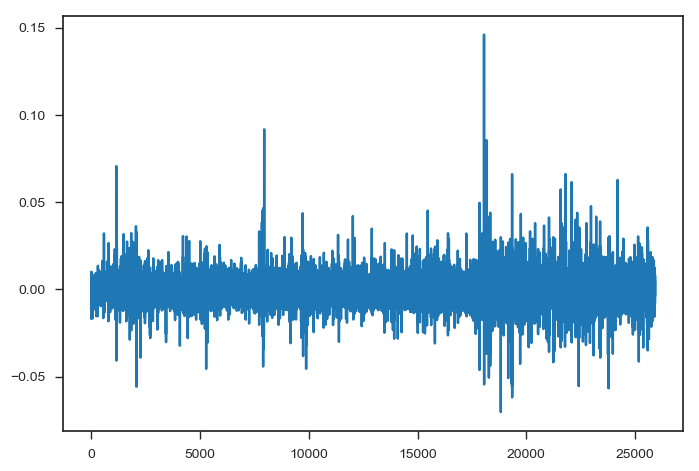

In [6]:
plt.plot(values)

In [7]:
# split into train and test sets
values = reframed.values
tts = int(len(values) * 0.7)
train = values[:tts, :]
test = values[tts:, :]
# split into input and outputs
n_features = int(reframed.shape[1]/(n_timesteps_in+1))
n_obs = n_timesteps_in * n_features
n_prd = reframed.shape[1] - n_obs
train_X, train_y = train[:, :n_obs], train[:, -n_prd:]
test_X, test_y = test[:, :n_obs], test[:, -n_prd:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps_in, n_features))
# train_y = train_y.reshape((train_y.shape[0], n_timesteps_out, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps_in, n_features))
# test_y = test_y.reshape((test_y.shape[0], n_timesteps_out, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(18116, 36) 18116 (18116, 3)
(18116, 36, 1) (18116, 3) (7764, 36, 1) (7764, 3)


In [23]:
from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

def create_network(num_gru_units, num_gru_layers, gru_activation, num_dense_units, num_dense_layers, dense_activation, dense_dropout, output_activation):
#     tbcallback = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#     early_stopping_monitor = callbacks.EarlyStopping(patience=2)

    # design network
    model = Sequential()
    # model.add(Dense(64, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(GRU(num_gru_units, input_shape=(train_X.shape[1], train_X.shape[2]), activation=gru_activation, return_sequences=True))
    for x in range(num_gru_layers):
        model.add(GRU(num_gru_units, activation=gru_activation, return_sequences=True))  # returns a sequence of vectors of dimension 32
    model.add(GRU(num_gru_units, activation=gru_activation))  # return a single vector of dimension 32
    for x in range(num_dense_layers):
        model.add(Dense(num_dense_units, activation=dense_activation))
        model.add(Dropout(dense_dropout))
    model.add(Dense(output_dim = train_y.shape[1], activation = output_activation)) #Output layer
    model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['accuracy'])
    return model

neural_network = KerasClassifier(build_fn=create_network, epochs=50, batch_size=1024, verbose=1)

In [24]:
hyperparameters = {
    'num_gru_units': [8], #[8, 32, 64],
    'num_gru_layers': [1], #[0, 1, 3, 5],
    'gru_activation': ['relu', 'sigmoid', 'linear'],
    'num_dense_units': [8], #[8, 32, 64],
    'num_dense_layers': [1], #np.arange(0, 5, 1),
    'dense_activation': ['relu', 'sigmoid', 'linear'],
    'dense_dropout': [0.0], #[0.0, 0.001, 0.01, 0.1, 0.3],
    'output_activation': ['relu', 'sigmoid', 'linear']
}

# fit_parameters = {
#     'validation_data': [(test_X, test_y)],
#     'batch_size': [1024],
#     'epochs': [1000]
# }

t = 0
for k, v in hyperparameters.items():
    print(k, len(v))
    print(t)
    t = t * len(v)
    if t == 0:
        t = len(v)
print(t)

num_gru_units 1
0
num_gru_layers 1
1
gru_activation 3
1
num_dense_units 1
3
num_dense_layers 1
3
dense_activation 3
3
dense_dropout 1
9
output_activation 3
9
27


In [25]:
from sklearn.model_selection import GridSearchCV

# Create grid search
grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters, verbose=50, n_jobs=1)

# Fit grid search
grid_result = grid.fit(X=train_X, y=train_y)

# model = create_network(num_gru_units = 32, num_gru_layers = 3, gru_activation = 'linear', num_dense_units = 16, num_dense_layers = 5, dense_activation = 'linear', dense_dropout = 0.0, output_activation = 'linear')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] dense_activation=relu, dense_dropout=0.0, gru_activation=relu, num_dense_layers=1, num_dense_units=8, num_gru_layers=1, num_gru_units=8, output_activation=relu 
Epoch 1/50
12077/12077 [==============================] - 6s 520us/step - loss: 4.3226e-05 - acc: 0.3440
Epoch 2/50
12077/12077 [==============================] - 1s 86us/step - loss: 4.1798e-05 - acc: 0.3565
Epoch 3/50
12077/12077 [==============================] - 1s 88us/step - loss: 4.1798e-05 - acc: 0.3565
Epoch 4/50
12077/12077 [==============================] - 1s 86us/step - loss: 4.1798e-05 - acc: 0.3565
Epoch 5/50
12077/12077 [==============================] - 1s 84us/step - loss: 4.1798e-05 - acc: 0.3565
Epoch 6/50
12077/12077 [==============================] - 1s 87us/step - loss: 4.1798e-05 - acc: 0.3565
Epoch 7/50
12077/12077 [==============================] - 1s 88us/step - loss: 4.1798e-05 - acc: 0.3565
Epoch 8/50
12077/12077 [====================

12077/12077 [==============================] - 1s 81us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 22/50
12077/12077 [==============================] - 1s 82us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 23/50
12077/12077 [==============================] - 1s 81us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 24/50
12077/12077 [==============================] - 1s 84us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 25/50
12077/12077 [==============================] - 1s 82us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 26/50
12077/12077 [==============================] - 1s 80us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 27/50
12077/12077 [==============================] - 1s 83us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 28/50
12077/12077 [==============================] - 1s 80us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 29/50
12077/12077 [==============================] - 1s 81us/step - loss: 3.9779e-05 - acc: 0.3602
Epoch 30/50
12077/12077 [==============================] - 1s 81us/

KeyboardInterrupt: 

In [11]:
grid_result.best_params_

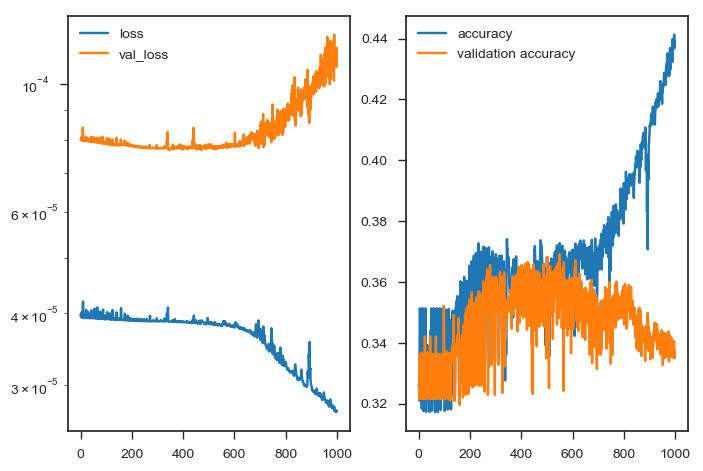

18116/18116 [==============================] - 4s 205us/step - loss: 2.7107e-05 - acc: 0.4390 - val_loss: 1.1564e-04 - val_acc: 0.3371


In [16]:
# fit network
# history = model.fit(train_X, train_y, epochs=400, batch_size=1024, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[plot_learning])

In [ ]:
for x in range(20):
    history = model.fit(train_X, train_y, epochs=500, batch_size=512, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    print(x)
    
    view = 0
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.set_title('Loss')
    ax1.plot(history.history['loss'][-view:], label='train')
    ax1.plot(history.history['val_loss'][-view:], label='test')

    ax2.set_title('Accuracy')
    ax2.plot(history.history['acc'][-view:], label='train')
    ax2.plot(history.history['val_acc'][-view:], label='test')

    plt.legend()
    plt.show()

In [ ]:
# model.save('model_attempt4.h5')

In [ ]:
# plot training
view = 0
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_title('Loss')
ax1.plot(history.history['loss'][-view:], label='train')
ax1.plot(history.history['val_loss'][-view:], label='test')

ax2.set_title('Accuracy')
ax2.plot(history.history['acc'][-view:], label='train')
ax2.plot(history.history['val_acc'][-view:], label='test')

plt.legend()
plt.show()

In [6]:
model.evaluate(x=test_X, y=test_y)

NameError: name 'model' is not defined

In [32]:
def predict(df, points):
    before = df[:, 0, -1].flatten()
    plt.plot(before, label='before')
    for point in points:
        after = model.predict(df[:point])[-1]
        padding = [None for p in range(point+1)]
        plt.plot(np.concatenate([padding, after]), label='after')
    plt.legend()
    plt.show() 

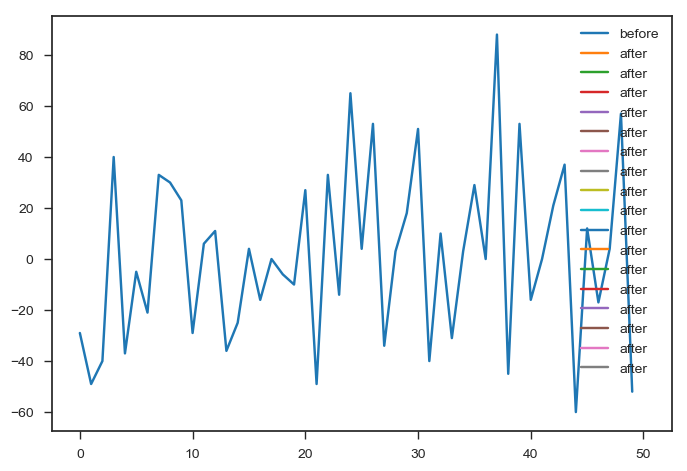

In [33]:
# print(test_X.shape)
# print(test_X[:1].shape)
predict(test_X[0:50], range(1, 50, 3))

temp [[[ -29.]
  [   6.]
  [  11.]
  [ -36.]
  [ -25.]
  [   4.]
  [ -16.]
  [   0.]
  [  -6.]
  [ -10.]
  [  27.]
  [ -49.]
  [  33.]
  [ -14.]
  [  65.]
  [   4.]
  [  53.]
  [ -34.]
  [   3.]
  [  18.]
  [  51.]
  [ -40.]
  [  10.]
  [ -31.]
  [   3.]
  [  29.]
  [   0.]
  [  88.]
  [ -45.]
  [  53.]
  [ -16.]
  [   0.]
  [  21.]
  [  37.]
  [ -60.]
  [  12.]
  [ -17.]
  [   4.]
  [  57.]
  [ -52.]
  [  13.]
  [  43.]
  [ -39.]
  [  50.]
  [  -1.]
  [  18.]
  [   3.]
  [   7.]
  [  18.]
  [  -9.]
  [  35.]
  [  27.]
  [   9.]
  [  32.]
  [  -8.]
  [  35.]
  [  23.]
  [  47.]
  [ -13.]
  [-100.]
  [ -21.]
  [  -3.]
  [ -18.]
  [  15.]
  [ 217.]
  [   6.]
  [  23.]
  [ -11.]
  [  19.]
  [ -75.]
  [  39.]
  [ -38.]]]
test_y[5:6] [[-11.]]
aaa [[ 0.44189346]]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

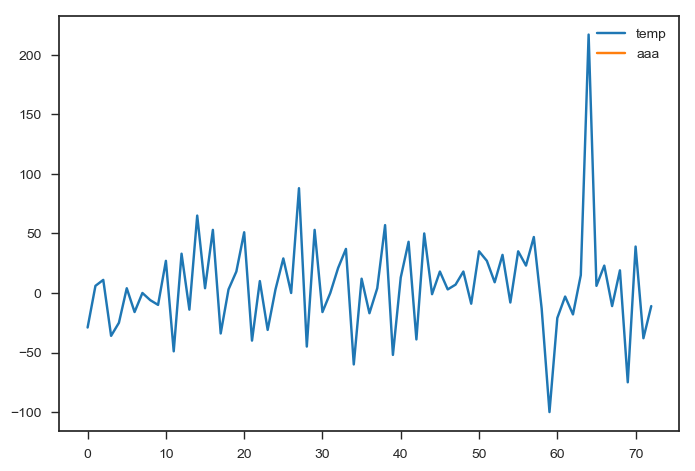

In [34]:
temp = test_X[10:11]
print('temp', temp)
print('test_y[5:6]', test_y[10:11])
aaa = model.predict(temp)
print('aaa', aaa)
padding = [None for p in range(len(temp.flatten()))]
print(padding)
plt.plot(np.concatenate([temp.flatten(), test_y[10:11].flatten()]), label='temp')
plt.plot(np.concatenate([padding, aaa[0]]), label='aaa')
plt.legend()
plt.show() 